In [45]:
import cv2
import numpy as np
import imutils
import os
import shutil
from matplotlib import pyplot as plt
from types import SimpleNamespace

In [13]:
original_file_name = "acord-25-form-fillable-free.jpg"

file_ready_for_line_detect = os.path.splitext(original_file_name)[0] + "-ready-for-line-detect" + os.path.splitext(original_file_name)[1]
file_ready_only_lines = os.path.splitext(original_file_name)[0] + "-only-lines-final" + os.path.splitext(original_file_name)[1]
sample_images_path = os.path.join(os.path.dirname(os.path.realpath("__file__")),"../sample-images")
cropped_dir_path = os.path.dirname(os.path.realpath("__file__")) + "/output/seg"
temp_dir_path = os.path.join(cropped_dir_path, "temp")
phase1_path = os.path.join(cropped_dir_path,"phase1")
phase2_path = os.path.join(cropped_dir_path,"phase2")
file_ready_for_lines_detection_path = os.path.join(cropped_dir_path, file_ready_for_line_detect)
original_image_path = os.path.join(sample_images_path, original_file_name)
file_only_lines_final_path = os.path.join(cropped_dir_path,"phase1",file_ready_only_lines)

print("sample_images = " + sample_images_path)
print("cropped dir = "+cropped_dir_path)
print("phase1_path = "+phase1_path)
print("original_image_path = "+original_image_path)
print("file_ready_for_line_detection_path = "+file_ready_for_lines_detection_path)

sample_images = /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/../sample-images
cropped dir = /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/output/seg
phase1_path = /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/output/seg/phase1
original_image_path = /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/../sample-images/acord-25-form-fillable-free.jpg
file_ready_for_line_detection_path = /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/output/seg/acord-25-form-fillable-free-ready-for-line-detect.jpg


In [3]:
# img = cv2.imread("acord-125-sample.jpg", 0)
img = cv2.imread(file_ready_for_lines_detection_path ,0)
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)

In [4]:
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 19
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

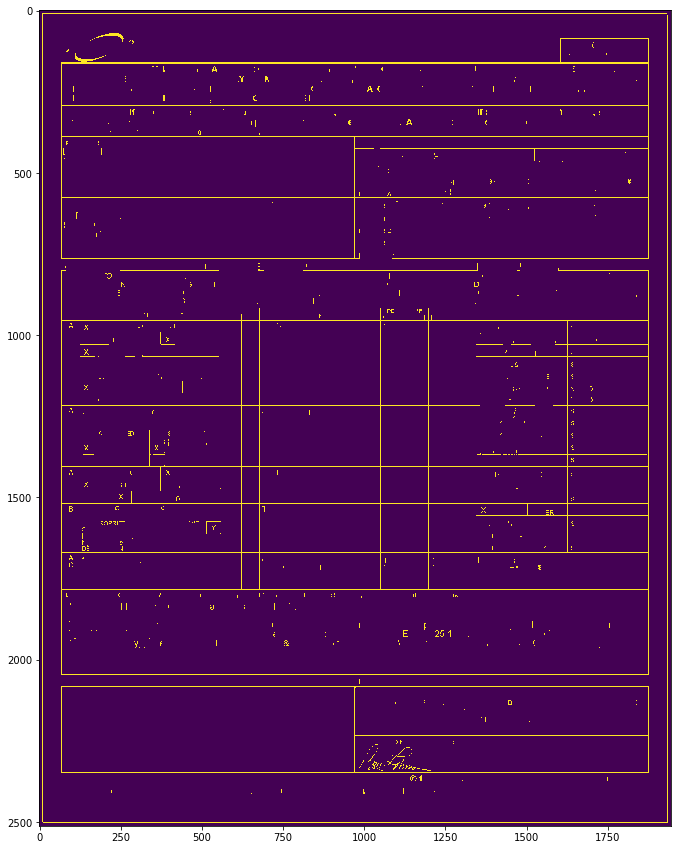

In [5]:
# Invert the image
img_bin = 255-img_bin 
plt.imshow(img_bin)

In [6]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
kernel_length = 3 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
kernel_length = 4
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
print(hori_kernel)
print(verticle_kernel)
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

[[1 1 1 1]]
[[1]
 [1]
 [1]]


In [7]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=5)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=5)
#cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=5)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=5)
#cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)

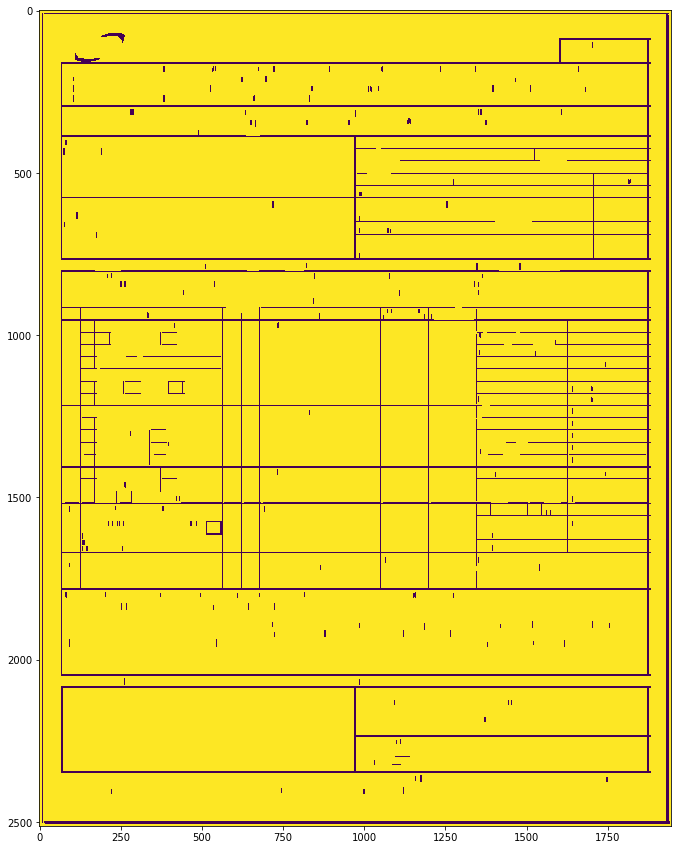

In [14]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=1)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(file_only_lines_final_path,img_final_bin)
plt.imshow(img_final_bin)

In [9]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
 
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
 
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
 
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
 
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [10]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

In [49]:
def remove_duplicate_blocks(rects):
    
    clear_rects = []
    
    for r1 in rects:
        
        found = False
        print(str(r1))
        for r2 in rects:                        
            if ((r2.x + r2.w)  < (r1.x+r1.w)) and (r2.x > r1.x) and (r2.y > r1.y) and ((r2.y+r2.h) < (r1.y+r1.h)):                                            
                found = True
        
        if not found:
            clear_rects.append(r1)
    
    print(clear_rects)
    return clear_rects


In [54]:
idx = 0
img_tru = cv2.imread(original_image_path,0)
print("about to remove all files from "+phase1_path)
try:
    shutil.rmtree(phase1_path)
except Exception as e:
    print(e)
os.mkdir(phase1_path)

bounding_rects = []
for c in contours:       
    x, y, w, h = cv2.boundingRect(c)    
    if (w > 5 and h > 5) and w >= 1*h:
        r = {'x':x,'y':y,'w':w,'h':h}
        n = SimpleNamespace(**r)
        bounding_rects.append(n)

# print(bounding_rects)
dedupe_rects = remove_duplicate_blocks(bounding_rects)

#print(str(c.size))
#print(boundingBoxes)
for r in dedupe_rects:
    # Returns the location and width,height for every contour        
    idx += 1
    new_img = img_tru[r.y:r.y+r.h, r.x:r.x+r.w]
    cv2.imwrite(phase1_path+"/"+str(idx) + '.png', new_img)
print("completed splitting the image to blocks into "+phase1_path)

about to remove all files from /mnt/c/Users/mahesh.m/Documents/ProjPyWorkspace/EAST/output/seg/phase1
namespace(h=33, w=77, x=189, y=69)
namespace(h=686, w=1820, x=66, y=84)
namespace(h=69, w=265, x=1609, y=91)
namespace(h=126, w=1802, x=72, y=166)
namespace(h=89, w=1802, x=72, y=298)
namespace(h=146, w=898, x=976, y=392)
namespace(h=184, w=898, x=72, y=392)
namespace(h=34, w=165, x=1709, y=504)
namespace(h=35, w=165, x=1709, y=541)
namespace(h=35, w=730, x=976, y=541)
namespace(h=72, w=165, x=1709, y=579)
namespace(h=110, w=730, x=976, y=579)
namespace(h=184, w=898, x=72, y=579)
namespace(h=35, w=165, x=1709, y=654)
namespace(h=71, w=165, x=1709, y=692)
namespace(h=72, w=730, x=976, y=692)
namespace(h=1272, w=1820, x=66, y=778)
namespace(h=147, w=1802, x=72, y=806)
namespace(h=34, w=144, x=1054, y=918)
namespace(h=34, w=437, x=128, y=918)
namespace(h=34, w=53, x=72, y=918)
namespace(h=33, w=244, x=1630, y=957)
namespace(h=258, w=370, x=681, y=957)
namespace(h=258, w=437, x=128, y=957)